In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from pyspark.ml.classification import RandomForestClassifier
from xgboost import XGBClassifier



In [ ]:
!pip3 install pyspark pyarrow --break-system-packages
%env JAVA_HOME=/opt/homebrew/opt/openjdk@17

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = (
    SparkSession.builder
    .appName("crime_hotspot")
    .config("spark.local.dir", "/Users/kiranghumare/spark_tmp")
    .config("spark.sql.shuffle.partitions", "50")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "4g")
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.driver.host", "127.0.0.1")
    .config("spark.blockManager.port", "0") 
    .config("spark.ui.port", "4050")
    .getOrCreate()
)

print("✓ Spark session initialized for Week 4!")

# Load the data
df = spark.read.parquet("../data/processed/integrated_crime_data.parquet")

env: JAVA_HOME=/opt/homebrew/opt/openjdk@17
✓ Spark session initialized for Week 4!


In [ ]:
def get_crime_category(crime):
    violent = ['BATTERY', 'ASSAULT', 'ROBBERY', 'HOMICIDE', 'CRIM SEXUAL ASSAULT', 'SEX OFFENSE', 'KIDNAPPING']
    property = ['THEFT', 'BURGLARY', 'MOTOR VEHICLE THEFT', 'CRIMINAL DAMAGE', 'ARSON']
    drug_vice = ['NARCOTICS', 'LIQUOR LAW VIOLATION', 'GAMBLING', 'PROSTITUTION']
    
    if crime in violent: return 'Violent'
    if crime in property: return 'Property'
    if crime in drug_vice: return 'Drug/Vice'
    return 'Other'

df = df.toPandas()
df['crime_category'] = df['crime_type'].apply(get_crime_category)

print("New class breakdown:")
print(df['crime_category'].value_counts(normalize=True))

New class breakdown:
crime_category
Property     0.441341
Violent      0.316405
Other        0.207280
Drug/Vice    0.034974
Name: proportion, dtype: float64


In [ ]:
# splitting data into training, test and validation sets
df.head()
# df['date_ts'] = df['date_ts'].dt.strftime('%Y-%m-%d %H:%M:%S')
days_of_week_map = {'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat': 6, 'Sun': 0}
season_map = {'spring': 1, 'summer': 2, 'fall': 3, 'winter': 4}
df['dayofweek'] = df['dayofweek'].map(days_of_week_map)
df['season'] = df['season'].map(season_map)
df['temp_mean'] = df['temp_mean'].bfill()
df['precipitation'] = df['precipitation'].bfill()
df['wind_speed'] = df['wind_speed'].bfill()
df['community_area'].fillna(df['community_area'].mean(axis=0), inplace=True)
df['per_capita_income'].fillna(df['per_capita_income'].mean(axis=0), inplace=True)
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
# X = df[['latitude', 'longitude','community_area','temp_mean','precipitation','wind_speed','year','month','hour','dayofweek','season']]
# X = df[['latitude', 'longitude','community_area','year','hour']]
X = df[['latitude', 'longitude', 'hour']]
# y = df['crime_category']
crime_category_map = {'Drug/Vice': 0, 'Property':1, 'Violent': 2,  'Other':3 }
df['crime_category'] = df['crime_category'].map(crime_category_map)
y = df['crime_category']
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=9)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.15, random_state=9)

# df.isna()
X_train.isna().sum(), y_train.isna().sum()

df.isna().sum()
print(np.unique(y))
y.isna().sum()

/var/folders/j9/kq2bk67n4b1_cd_g8kcxdg0m0000gn/T/ipykernel_52470/673554206.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['community_area'].fillna(df['community_area'].mean(axis=0), inplace=True)
/var/folders/j9/kq2bk67n4b1_cd_g8kcxdg0m0000gn/T/ipykernel_52470/673554206.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on whic

[0 1 2 3]


np.int64(0)

In [ ]:
log_model = LogisticRegression(penalty=None, tol=0.0001, solver='saga')
log_model.fit(X_train, y_train)
y_val_pred = log_model.predict(X_val)
y_test_pred = log_model.predict(X_test)
print(np.unique(y_val_pred))

[1 2]


In [32]:
acc_val = accuracy_score(y_val, y_val_pred)
acc_test = accuracy_score(y_test, y_test_pred)
acc_val, acc_test
# y_val_pred = y_val_pred
# y_val_pred=y_val_pred.sort()
# y_val_pred

(0.4363062396000032, 0.43641107024305403)

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_val_pred = dtc.predict(X_val)
y_test_pred = dtc.predict(X_test)
acc_val = accuracy_score(y_val, y_val_pred)
acc_test = accuracy_score(y_test, y_test_pred)
acc_val, acc_test

(0.4211948949451039, 0.4208763209274154)

In [7]:
# using Random Forest
# rf = RandomForestClassifier(n_estimators=60,
#  min_samples_split=5,
#  min_samples_leaf=1,
#  max_samples=0.5,
#  max_features=0.6,
#  max_depth=8,
#  bootstrap=True)

rf = RandomForestClassifier(n_estimators=120,
 min_samples_split=5,
 min_samples_leaf=1,
 max_samples=None,
 max_features=0.6,
 max_depth=8,
 bootstrap=True)
rf.fit(X_train, y_train)
y_val_pred = rf.predict(X_val)
y_test_pred = rf.predict(X_test)
acc_val = accuracy_score(y_val, y_val_pred)
acc_test = accuracy_score(y_test, y_test_pred)
acc_val, acc_test
print(rf.feature_importances_)

[0.33139592 0.2637328  0.18107498 0.04581347 0.17798283]


In [8]:
# X = df[['latitude', 'longitude','community_area','year','hour']]
y_val_pred = rf.predict(X_val)
y_test_pred = rf.predict(X_test)
acc_val = accuracy_score(y_val, y_val_pred)
acc_test = accuracy_score(y_test, y_test_pred)
acc_val, acc_test

(0.4572455633315021, 0.4572312210901733)

In [ ]:
# Number of trees in random forest
n_estimators = [20,40, 60, 100, 120]

# Number of features to consider at every split
max_features = [0.2,0.6,1.0]

# Maximum number of levels in tree
max_depth = [2,8,None]

# Number of samples
max_samples = [0.5,0.75,1.0]

# Bootstrap samples
bootstrap = [True,False]

# Minimum number of samples required to split a node
min_samples_split = [2, 5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]

param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'max_samples':max_samples,
              'bootstrap':bootstrap,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf
             }
print(param_grid)

{'n_estimators': [20, 40, 60, 100, 120], 'max_features': [0.2, 0.6, 1.0], 'max_depth': [2, 8, None], 'max_samples': [0.5, 0.75, 1.0], 'bootstrap': [True, False], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier()
rf_grid = RandomizedSearchCV(estimator = rf, 
                       param_distributions = param_grid, 
                       cv = 5, 
                       verbose=2, 
                       n_jobs = -1)

In [ ]:
X_small = X_train.sample(frac=0.1, random_state=42)
y_small = y_train.sample(frac=0.1, random_state=42)
X_small.info()
rf_grid.fit(X_small,y_small)

<class 'pandas.core.frame.DataFrame'>
Index: 142347 entries, 1257492 to 1390015
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   latitude        142347 non-null  float64
 1   longitude       142347 non-null  float64
 2   community_area  142347 non-null  float64
 3   year            142347 non-null  int32  
 4   hour            142347 non-null  int32  
dtypes: float64(3), int32(2)
memory usage: 5.4 MB
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=False, max_depth=8, max_features=1.0, max_samples=0.75, min_samples_leaf=1, min_samples_split=5, n_estimators=40; total time=   0.1s
[CV] END bootstrap=False, max_depth=8, max_features=1.0, max_samples=0.75, min_samples_leaf=1, min_samples_split=5, n_estimators=40; total time=   0.1s
[CV] END bootstrap=False, max_depth=8, max_features=1.0, max_samples=0.75, min_samples_leaf=1, min_samples_split=5, n_estimators=40; total time=   0.1s

/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_forest.py", line 430, in fit
    raise ValueError(

,estimator,RandomForestClassifier()
,param_distributions,"{'bootstrap': [True, False], 'max_depth': [2, 8, ...], 'max_features': [0.2, 0.6, ...], 'max_samples': [0.5, 0.75, ...], ...}"
,n_iter,10
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [ ]:
rf_grid.best_params_

{'n_estimators': 120,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_samples': 1.0,
 'max_features': 0.6,
 'max_depth': 8,
 'bootstrap': True}

In [ ]:
rf_grid.best_score_

np.float64(0.45983407706652935)

In [ ]:
xg = XGBClassifier(
    objective='multi:softprob',
    num_class=len(y.unique()),
    tree_method='hist',
    booster='gbtree',

    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,

    eval_metric='mlogloss'
)

xg.fit(X_train, y_train)


,objective,'multi:softprob'
,base_score,None
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [34]:
y_val_pred = xg.predict(X_val)
y_test_pred = xg.predict(X_test)
acc_val = accuracy_score(y_val, y_val_pred)
acc_test = accuracy_score(y_test, y_test_pred)
acc_val, acc_test

(0.47096758783767645, 0.47059699320883425)

In [35]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(xg, X_train, y_train, cv=3, scoring='accuracy')
print(scores.mean())

0.4704676520032344


In [36]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

search = RandomizedSearchCV(
    estimator=xg,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=1
)
X_small = X_train.sample(frac=0.1, random_state=42)
y_small = y_train.sample(frac=0.1, random_state=42)
X_small.info()
# rf_grid.fit(X_small,y_small)
search.fit(X_small, y_small)


<class 'pandas.core.frame.DataFrame'>
Index: 142347 entries, 1257492 to 1390015
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   latitude   142347 non-null  float64
 1   longitude  142347 non-null  float64
 2   hour       142347 non-null  int32  
dtypes: float64(2), int32(1)
memory usage: 3.8 MB
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.7; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.7; total time=

,estimator,"XGBClassifier..._class=4, ...)"
,param_distributions,"{'colsample_bytree': [0.7, 0.8, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [4, 6, ...], 'n_estimators': [100, 200, ...], ...}"
,n_iter,10
,scoring,'accuracy'
,n_jobs,1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [38]:
search.best_params_

{'subsample': 0.8,
 'n_estimators': 300,
 'max_depth': 4,
 'learning_rate': 0.1,
 'colsample_bytree': 1.0}

In [39]:
search.best_score_

np.float64(0.4618010916984552)

In [ ]:
xg = XGBClassifier(
    objective='multi:softprob',
    num_class=len(y.unique()),
    tree_method='hist',
    booster='gbtree',

    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.7,
    colsample_bytree=0.8,
    eval_metric='mlogloss'
)

xg.fit(X_train, y_train)


,objective,'multi:softprob'
,base_score,None
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [41]:
y_val_pred = xg.predict(X_val)
y_test_pred = xg.predict(X_test)
acc_val = accuracy_score(y_val, y_val_pred)
acc_test = accuracy_score(y_test, y_test_pred)
acc_val, acc_test

(0.4682048709803266, 0.4668478095360554)

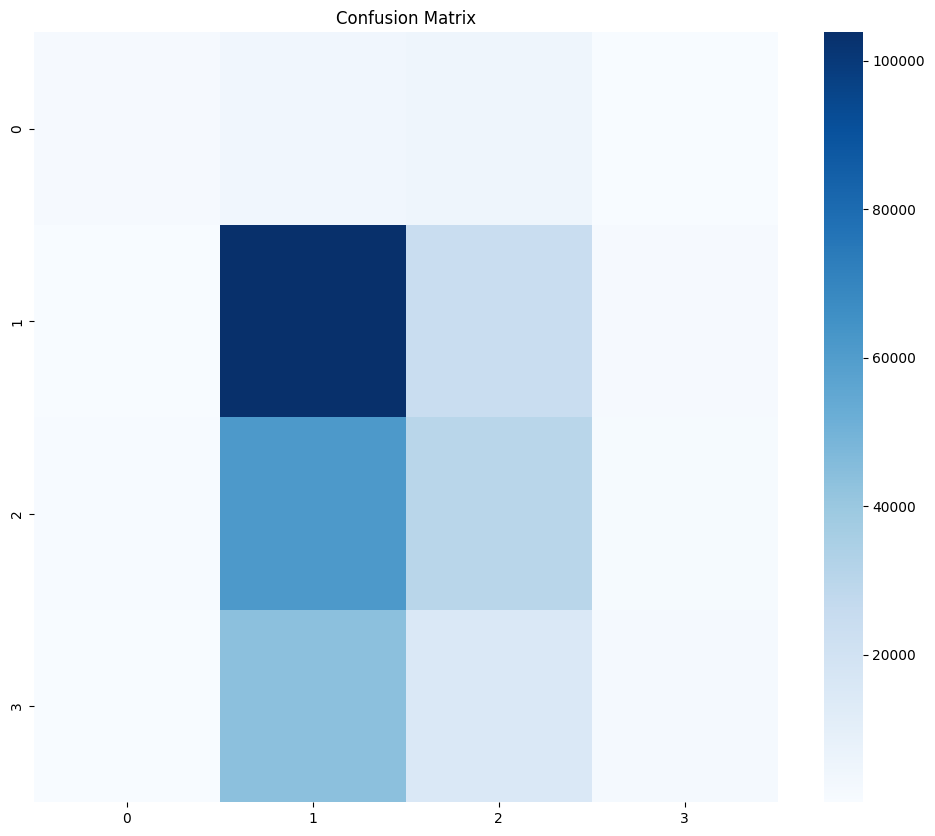

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = xg.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight


weights = compute_sample_weight(class_weight='balanced', y=y_train)

xg.fit(
    X_train, 
    y_train, 
    sample_weight=weights,
    verbose=True
)

,objective,'multi:softprob'
,base_score,None
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [44]:
y_val_pred = xg.predict(X_val)
y_test_pred = xg.predict(X_test)
acc_val = accuracy_score(y_val, y_val_pred)
acc_test = accuracy_score(y_test, y_test_pred)
acc_val, acc_test

(0.3854905613808807, 0.38454172320331875)

In [ ]:
from sklearn.metrics import balanced_accuracy_score, classification_report

print(f"Standard Acc: {accuracy_score(y_test, y_pred):.2%}")
print(f"Balanced Acc: {balanced_accuracy_score(y_test, y_pred):.2%}")
print(classification_report(y_test, y_pred))

Standard Acc: 46.68%
Balanced Acc: 32.83%
              precision    recall  f1-score   support

           0       0.50      0.16      0.24     10352
           1       0.49      0.80      0.61    130327
           2       0.41      0.33      0.36     93507
           3       0.44      0.03      0.06     61345

    accuracy                           0.47    295531
   macro avg       0.46      0.33      0.32    295531
weighted avg       0.45      0.47      0.40    295531



In [46]:
import joblib

joblib.dump(xg, "crime_model.pkl")

['crime_model.pkl']

In [47]:
feature_names = ["hour", "lat", "lng"]

def predict_crime(hour, lat, lng):
    X_input = pd.DataFrame([[hour, lat, lng]], columns=feature_names)
    pred = xg.predict(X_input)
    return pred